In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the patient data
file_path = 'file_path to data'


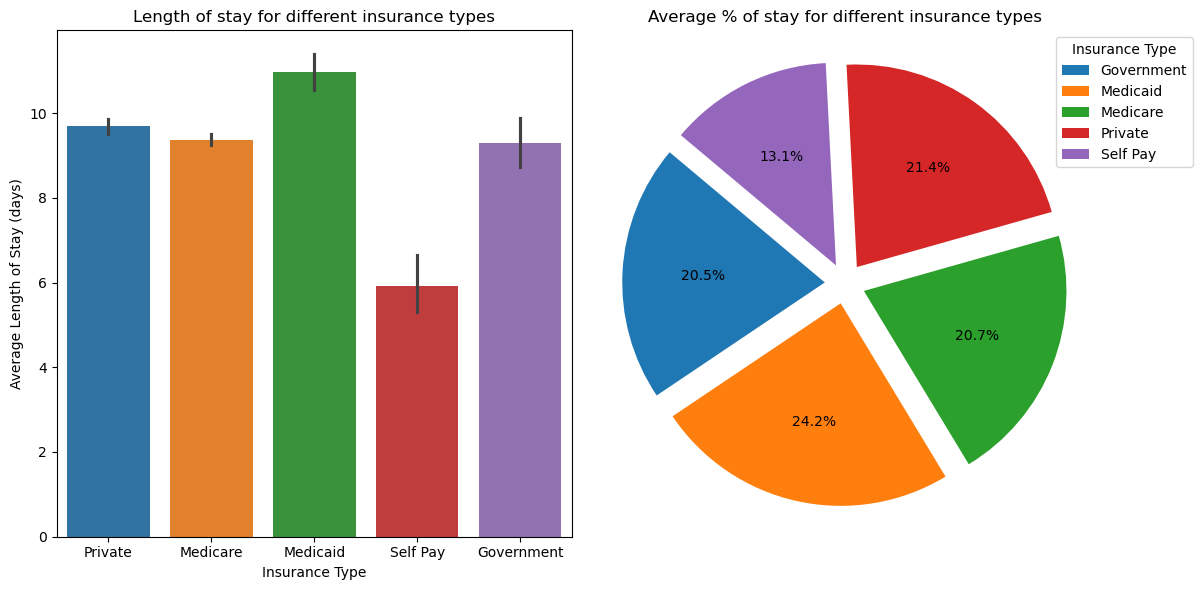

In [12]:
from datetime import datetime

admissiondf = pd.read_csv(file_path + 'Admissions.csv.gz')
df = admissiondf

#Calculate the length of stay
def calculate_stay(entry, exit):
    entry = datetime.strptime(entry, '%Y-%m-%d %H:%M:%S')
    exit = datetime.strptime(exit, '%Y-%m-%d %H:%M:%S')
    stay = (exit - entry).days 
    return stay

df['total_stay'] = df.apply(lambda row: calculate_stay(row['ADMITTIME'], row['DISCHTIME']), axis=1)

insurance_stay = df.groupby('INSURANCE')['total_stay'].mean()

#Plot a bar plot between length of stay and insurance type
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='INSURANCE', y='total_stay', hue='INSURANCE',  data=df)
plt.title('Length of stay for different insurance types')
plt.xlabel('Insurance Type')
plt.ylabel('Average Length of Stay (days)')

#Plot a pie chart between length of stay and insurance type
plt.subplot(1, 2, 2)
explode = [0.1] * len(insurance_stay)
plt.pie(insurance_stay, autopct='%1.1f%%', explode=explode, startangle=140)
plt.title('Average % of stay for different insurance types')
plt.legend(title='Insurance Type', loc='upper right', labels=insurance_stay.index, bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

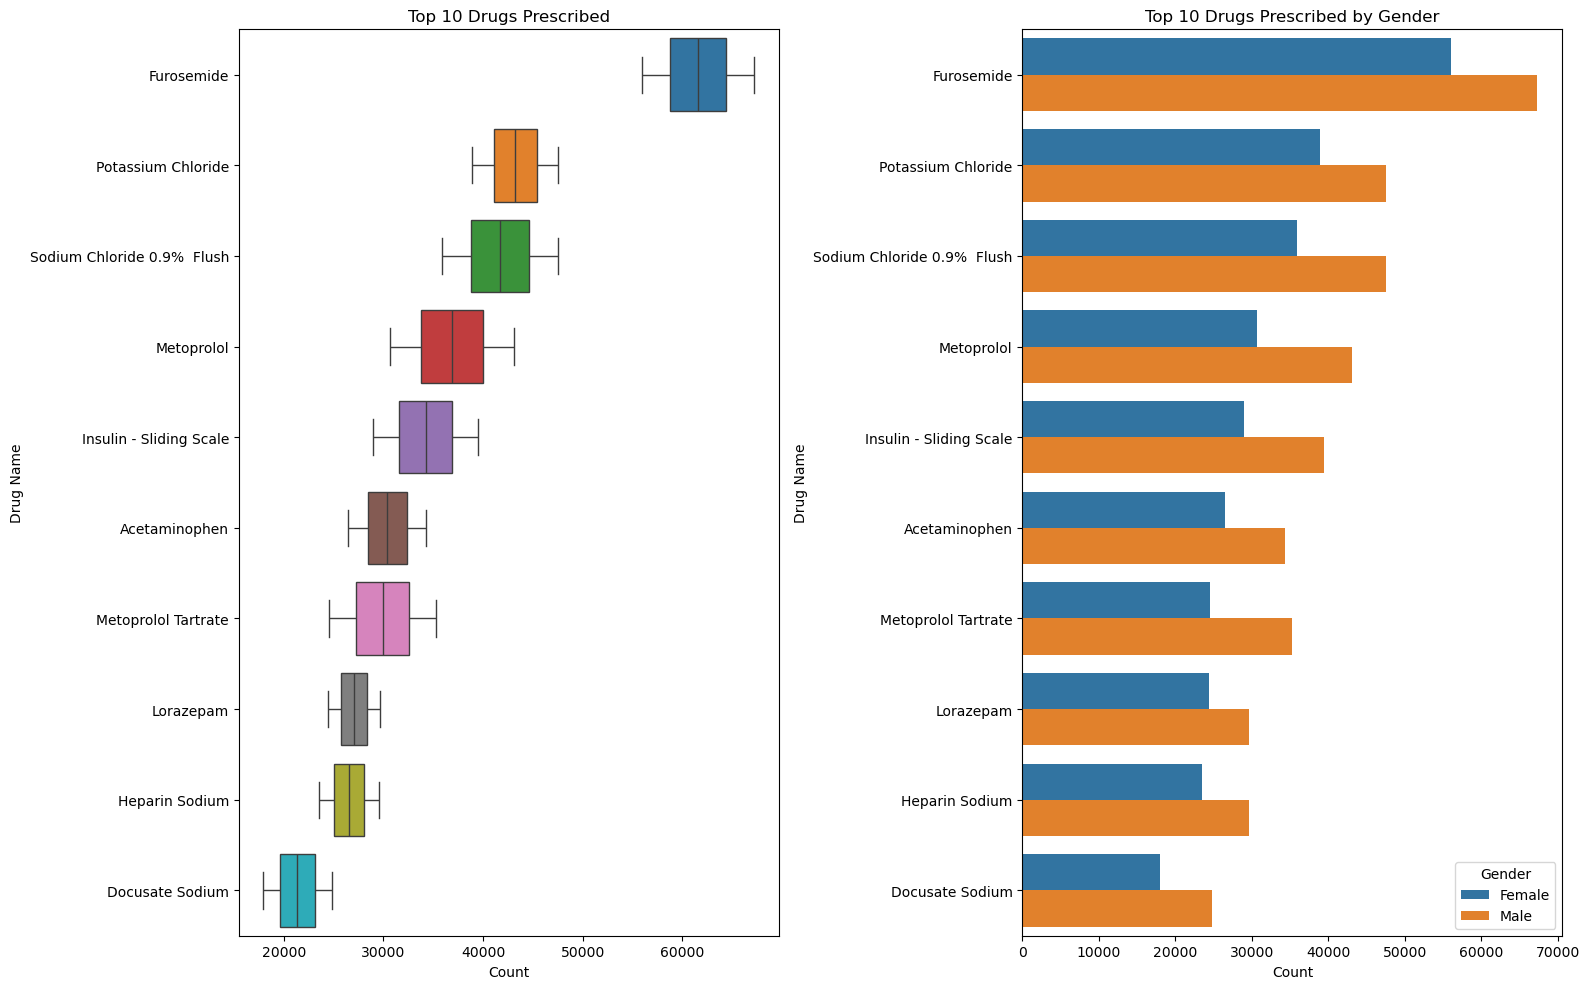

In [16]:
pescriptiondf = pd.read_csv(file_path + 'PRESCRIPTIONS.csv.gz', dtype={11: str})
patientdf = pd.read_csv(file_path + 'Patients.csv.gz')
#merge patient table and pescription table
merged_pescription_table = pd.merge(patientdf, pescriptiondf, on='SUBJECT_ID')

women_prescription = merged_pescription_table.query('GENDER == "F"')
men_prescription = merged_pescription_table.query('GENDER == "M"')

#count the number of prescriptions
women_drug_count = women_prescription['DRUG_NAME_GENERIC'].value_counts().head(10)
men_drug_count = men_prescription['DRUG_NAME_GENERIC'].value_counts().head(10)

#combine data on women and men drug count
top_prescriptions = pd.concat([women_drug_count, men_drug_count], axis=1, keys=['Female', 'Male']).fillna(0)

# Reset index for plotting
top_prescriptions = top_prescriptions.reset_index().melt(id_vars='DRUG_NAME_GENERIC', value_vars=['Female', 'Male'], var_name='Gender', value_name='Count')

# Rename columns for clarity
top_prescriptions.rename(columns={'index': 'DRUG_NAME_GENERIC'}, inplace=True)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.title('Top 10 Drugs Prescribed')
sns.boxplot(x='Count', y='DRUG_NAME_GENERIC', hue='DRUG_NAME_GENERIC', data=top_prescriptions)
plt.xlabel('Count')
plt.ylabel('Drug Name')

plt.subplot(1, 2, 2)
plt.title('Top 10 Drugs Prescribed by Gender')
sns.barplot(x ='Count', y='DRUG_NAME_GENERIC', hue='Gender', data=top_prescriptions)

plt.xlabel('Count')
plt.ylabel('Drug Name')

plt.tight_layout()
plt.show()

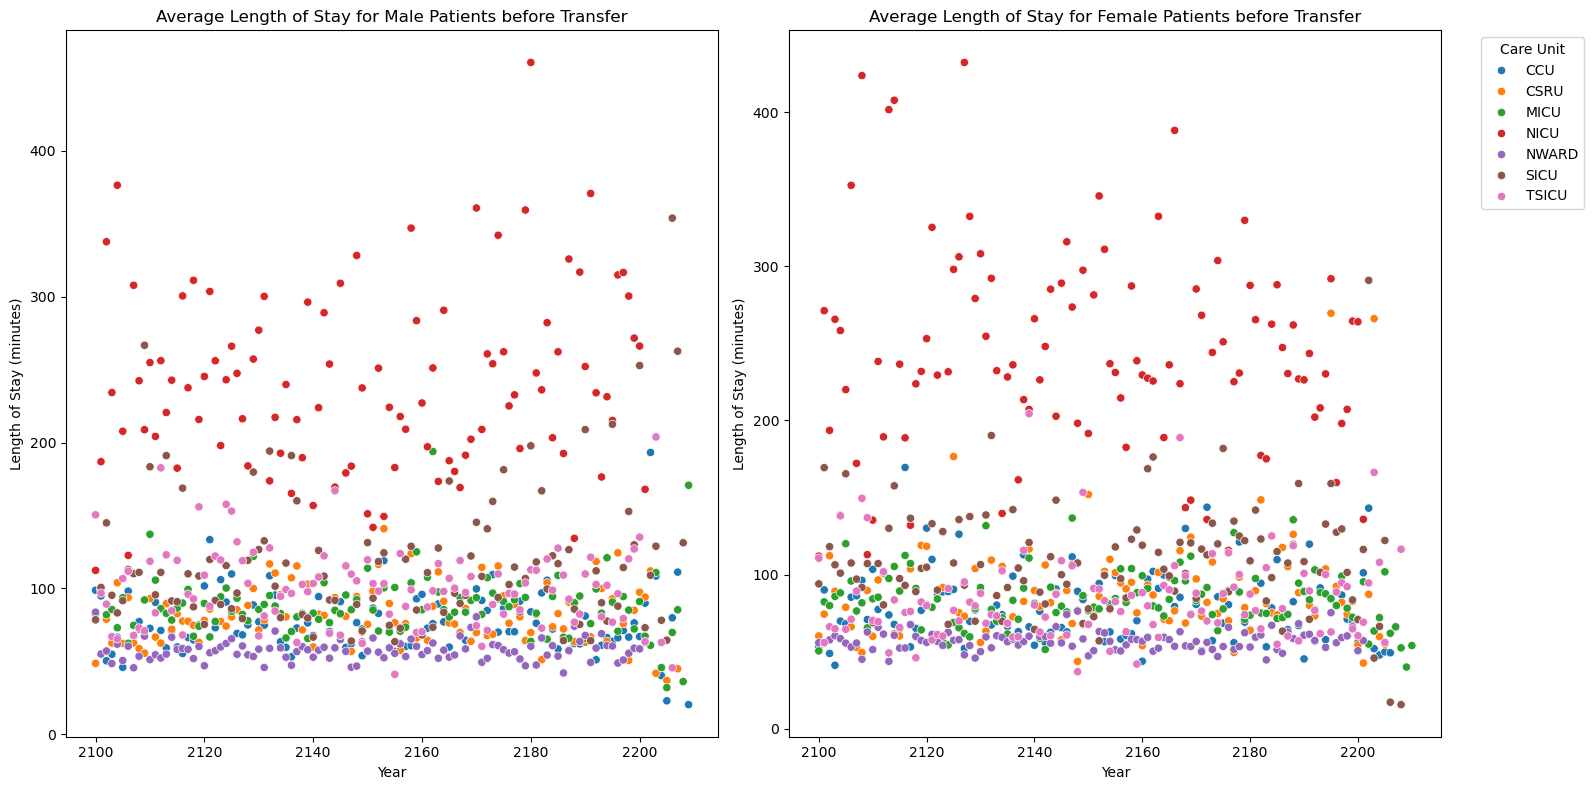

In [28]:
#Analyze the length of stay in minutes for the transfers based on current current unit
transfersdf = pd.read_csv(file_path +'TRANSFERS.csv.gz')
merged_admission_df = pd.merge(admissiondf, patientdf, on='SUBJECT_ID')
merged_transfer = pd.merge(transfersdf, merged_admission_df, on='SUBJECT_ID', how='inner')

# Convert 'INTIME' to datetime
merged_transfer['INTIME'] = pd.to_datetime(merged_transfer['INTIME'], errors='coerce')

#extract year from 'intime'
merged_transfer['intime_year'] = merged_transfer['INTIME'].dt.year

#Filter data for male and female patients
male_data = merged_transfer[(merged_transfer['GENDER'] == 'M') & (merged_transfer['LOS'] > 10)]
female_data = merged_transfer[(merged_transfer['GENDER'] == 'F') & (merged_transfer['LOS'] > 10)]

#Create scatterplot
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_for_male_patients = sns.scatterplot(data=male_data.groupby(['CURR_CAREUNIT', 'intime_year'])['LOS'].mean().reset_index(), 
                                         x='intime_year', y='LOS', hue='CURR_CAREUNIT', legend=False)
plt.title('Average Length of Stay for Male Patients before Transfer')
plt.xlabel('Year')
plt.ylabel('Length of Stay (minutes)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=female_data.groupby(['CURR_CAREUNIT', 'intime_year'])['LOS'].mean().reset_index(), x='intime_year', y='LOS', 
                hue='CURR_CAREUNIT', legend=True)
plt.title('Average Length of Stay for Female Patients before Transfer')
plt.xlabel('Year')
plt.ylabel('Length of Stay (minutes)')

plt.legend(title='Care Unit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




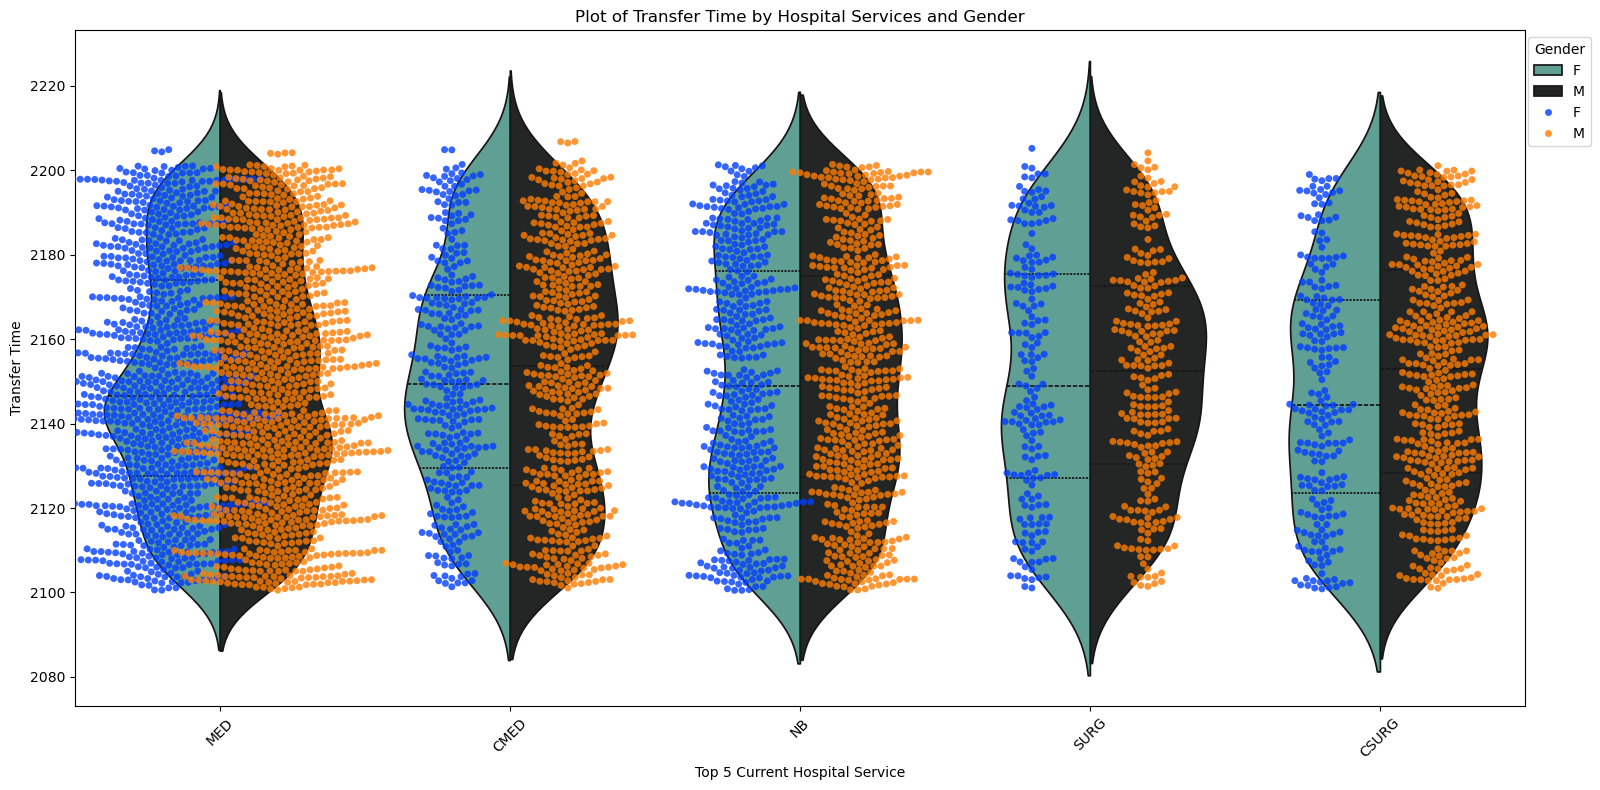

In [102]:
#merge servbices and patient data
servicesdf = pd.read_csv(file_path + 'SERVICES.csv.gz')
merged_services_df = pd.merge(servicesdf, patientdf, on='SUBJECT_ID')
merged_services_df['TRANSFERTIME'] = pd.to_datetime(merged_services_df['TRANSFERTIME'])

#Select the top 5 CURR_SERVICE values
top_services = merged_services_df['CURR_SERVICE'].value_counts().head(5).index

#Filter dataframe to include only top 5 services
top_services_df = merged_services_df[merged_services_df['CURR_SERVICE'].isin(top_services)]

#Combination of violin and swarm plot
plt.figure(figsize=(16, 8))
sns.violinplot(x='CURR_SERVICE', y='TRANSFERTIME', hue='GENDER', data=top_services_df.head(5000), 
               split=True, inner='quart', palette='dark:#5A9_r')
# Swarm plot
sns.swarmplot(x='CURR_SERVICE', y='TRANSFERTIME', hue='GENDER', data=top_services_df.head(5000), 
              dodge=True, alpha=0.8, size=5, palette='bright')
plt.xlabel('Top 5 Current Hospital Service')
plt.ylabel('Transfer Time')
plt.title('Plot of Transfer Time by Hospital Services and Gender')
plt.xticks(rotation=45)
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper right')
plt.tight_layout()
plt.show()


In [19]:
import plotly.express as px
diagnosesdf = pd.read_csv(file_path + 'DIAGNOSES_ICD.csv.gz')

data = pd.merge(diagnosesdf, patientdf, on='SUBJECT_ID')

#Get count of each ICD code for each gender
icd_counts_by_gender = data.groupby(['ICD9_CODE','GENDER']).size().reset_index(name='count')

top_icd_counts = icd_counts_by_gender.groupby('ICD9_CODE').sum().nlargest(20, 'count').reset_index()

top_icd_counts_by_gender = icd_counts_by_gender[icd_counts_by_gender['ICD9_CODE'].isin(top_icd_counts['ICD9_CODE'])]


#Create a bubble chart
fig = px.scatter(top_icd_counts_by_gender, x='ICD9_CODE', y='count', size='count', color='GENDER', hover_name='ICD9_CODE', 
                 size_max=60, title='Bubble Chart of Top 20 ICD Codes by Gender',
                 labels={'ICD9_CODE': 'ICD9 Code', 'count': 'Count'})

fig.update_layout(legend_title_text='Gender')
fig.show()


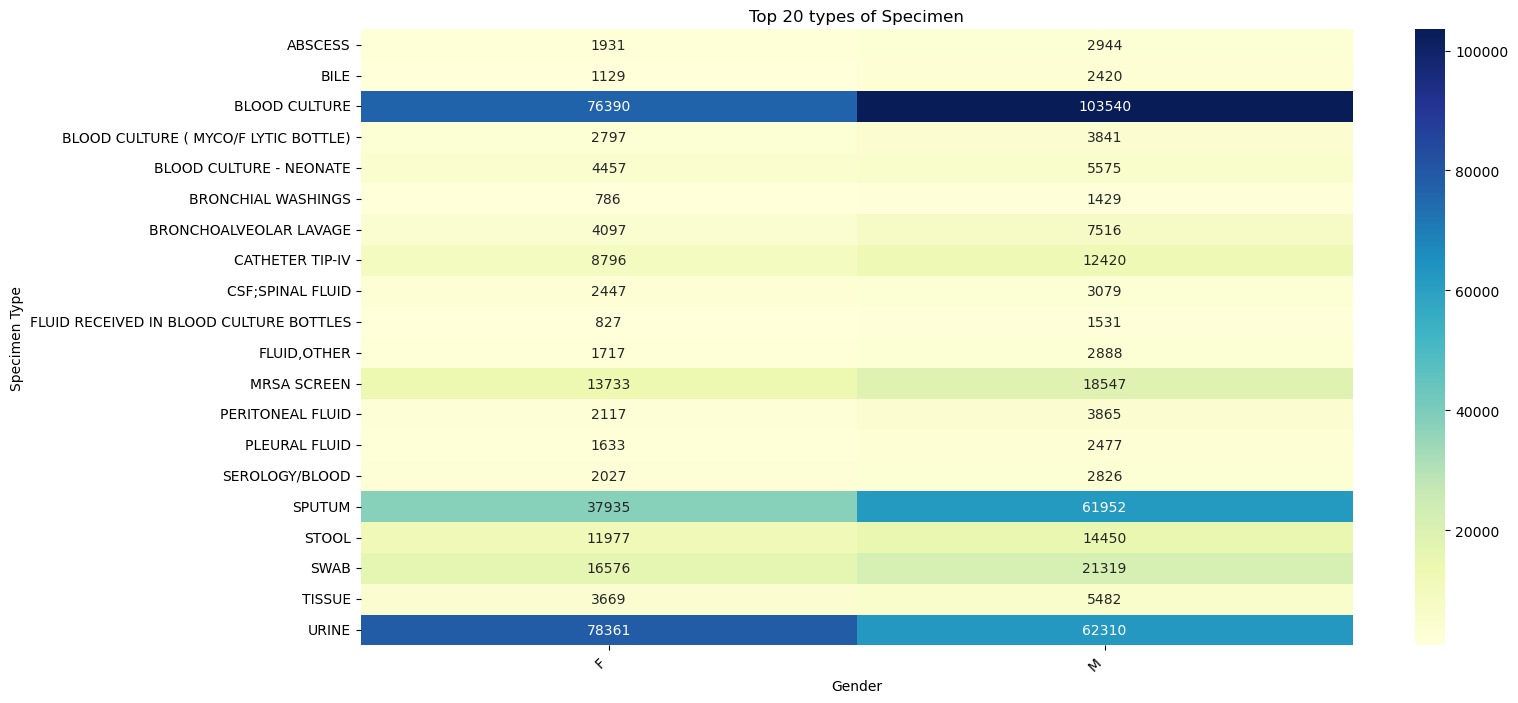

In [3]:
microbiologyeventsdf = pd.read_csv(file_path + 'MICROBIOLOGYEVENTS.csv.gz')

data_merge = pd.merge(patientdf, microbiologyeventsdf, on='SUBJECT_ID')

#Find top 20 specimen types
top_specimen_types = data_merge['SPEC_TYPE_DESC'].value_counts().head(20).index
filter_top_10_specimen = data_merge[data_merge['SPEC_TYPE_DESC'].isin(top_specimen_types)]

#group data by specimen type and gender
data = filter_top_10_specimen.groupby(['SPEC_TYPE_DESC', 'GENDER']).size().unstack().fillna(0)

#plot a heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(data, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Top 20 types of Specimen')
plt.xlabel('Gender')
plt.ylabel('Specimen Type')
plt.xticks(rotation=45, ha='right')
plt.show()
